# Import Libraries/Dataset (0 mark) 


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import glob
import requests 
import shutil 
from six.moves import urllib
import collections

In [ ]:
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

GPU is available


# Data Processing(1  mark) 

In [ ]:
# mounting the Google drive, as we have saved our dataset and the pickle file in the gdrive 
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Image dataset Folder : 
 https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing

In [ ]:
# Unzipping the image captioning dataset to contents directory in colab
!unzip -q gdrive/MyDrive/Assignments/DL_2/Image_captioning_Dataset.zip 

In [ ]:
print('Number of images in dataset : ',len(os.listdir(path='Flicker8k_Dataset')))

Number of images in dataset :  8091


Read the pickle file :  
(https://drive.google.com/file/d/1A8g74ohdb_5d2fPjc72yF7GxufE9GRcu/view?usp=sharing) (Links to an external site.) and convert the data into the correct format which could be used for ML model.




In [ ]:
# reading the pickle file to create the image to caption mapping
mapping_file=pd.read_pickle('gdrive/MyDrive/Assignments/DL_2/set_0.pkl')
# storing the image to caption mapping as a dictionary
map_dict = {}
for val in mapping_file:
    
    if val[:val.find("#")] in map_dict:
        map_dict[val[:val.find("#")]].append(val[val.find("\t")+1:])
    else:
        map_dict[val[:val.find("#")]] = [val[val.find("\t")+1:]]

In [ ]:
# checking for non 'jpg' type files in the mapping file and 
lst=list(map_dict.keys())
for val in lst:
    if not val.endswith(".jpg"):
        print("Found the following non-image file in the mapping file : ",val)

Found the following non-image file in the mapping file :  2258277193_586949ec62.jpg.1


In [ ]:
# there is no such file in the ditectory

files_datset=glob.glob('Flicker8k_Dataset/*.jpg.1', recursive=True)
print("Found the following non-image file in the dataset : ",files_datset)

Found the following non-image file in the dataset :  []


In [ ]:
# the file '2258277193_586949ec62.jpg.1' is not present in the dataset, so we are removing it from the dictionary
del map_dict['2258277193_586949ec62.jpg.1']
print("key removed successfully")

key removed successfully


**Plot at least two samples and their captions (use matplotlib/seaborn/any other library).**

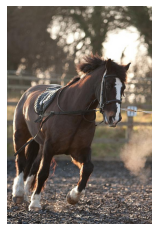

['A brown and white horse run in a gravel .', 'A large horse with gear , but no rider .', 'a horse run .']


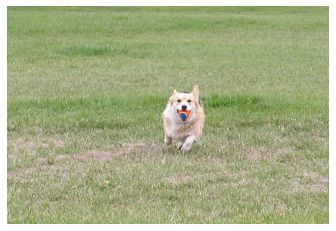

['a small tan dog run on the grass with a ball in his mouth', 'A dog with a blue ball run in a field .', 'small dog run in the grass with a toy in its mouth', 'Dog run towards camera with a ball in its mouth .']


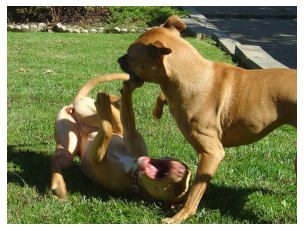

['Two dog play', 'Two yellow dog play-fighting .', 'Two tan dog play on the grass near the wall .', 'Two tan colored dog be roughhouse outdoors .']


In [ ]:
for i in range(3):
    rn =  np.random.randint(0, len(os.listdir(path='Flicker8k_Dataset')))
    img_name = list(map_dict.keys())[rn]
    caption = map_dict[img_name]

    i = plt.imread("/content/Flicker8k_Dataset"+"/"+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    print(caption)

**Cleaning text**

In [ ]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    
    return sample

In [ ]:
print("Text before cleaning : ",list(map_dict.items())[:5])
#  cleaning the captions using the above deined function

for key, desc_list in map_dict.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

print("Text cleaning successful")
print("Text after cleaning : ",list(map_dict.items())[:5])

Text before cleaning :  [('318667317_108c402140.jpg', ['A man in a black hoodie be hold a paper sign .', 'A homeless man carry a sign that say " hungry " .', 'A bearded man hold a sign .', 'A man in a black hoodie hold a small sign .']), ('2072574835_febf0c5fb9.jpg', ['Three race dog be run out of the start gate on a track .', 'Greyhound dog wear race stripe be run out of a gate on a track .', 'Dog in a race .']), ('3083016677_5782bc337c.jpg', ['Two motorcycle with two rider each .', 'There be two motorcycle with a man and a woman on it .', 'Two guy with helmet be on motorcycle , each with a woman ride behind him', 'Two motorcycle and four rider be on a road .']), ('95734038_2ab5783da7.jpg', ['A man on a bike nest to a river .', 'A man ride a bicycle on a rocky path beside a lake in the mountain .', 'A man stand astride a bike on a rocky trail by a lake .']), ('241346146_f27759296d.jpg', ['A football player try tackle another player who have the ball .', 'A Sooner football player carry

In [ ]:
# writing clean captions to .txt file and storing the descriptions in the form of a json

f = open("descriptions.txt","w")
f.write( str(map_dict) )
f.close()

#  reading description file
f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()
#storing the descriptions in the form of a json
json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
# finding the unique vocabulary 

vocabulary = set()

for key in map_dict.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print(f'Unique vocabulary Size: {len(vocabulary)}')

#  collecting all words in description dictionary
all_vocab =  []

for key in map_dict.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print(f'Total Vocabulary Size: {len(all_vocab)}' )
print("Sample of words in the dataset",all_vocab[500:515])

Unique vocabulary Size: 5293
Total Vocabulary Size: 226401
Sample of words in the dataset ['cloth', 'dog', 'bed', 'brown', 'dog', 'be', 'lay', 'down', 'on', 'blue', 'sheet', 'brown', 'dog', 'lay', 'on']


In [ ]:
# we have to count the frequency of each word, sort them and discard the words having frequency lesser than threshold value
# we have set the threshold value as 10 for requency of words

counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10
#sorting
sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
# removing count les than threshold values
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]
print("Corpus creation successul",f"\nThere are {len(all_vocab)} unique words in the corpus that we have created")
print("Sample of words in corpus are : ",all_vocab[700:715])

Corpus creation successul 
There are 1165 unique words in the corpus that we have created
Sample of words in corpus are :  ['machine', 'parachute', 'creek', 'cricket', 'match', 'pavement', 'competition', 'speak', 'begin', 'chain', 'mother', 'formation', 'christmas', 'neck', 'bank']


In [ ]:
# Splitting the dataset into train and test data

train=list(descriptions.keys())[:6000]
test=list(descriptions.keys())[6000:]
print(f"No.of images in train dataset {len(train)}",f"\nNo.of images in train dataset {len(test)}")

No.of images in train dataset 6000 
No.of images in train dataset 2036


In [ ]:
'''we have to create train_descriptions and test_descriptions dictionaries, having only corresponding samples
we are adding padding sequences at the end of each sentneces,
so that we can identiy the begining and ending of each individual sentences  
we use the tags : startseq and endseq''' 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

test_descriptions = {}

for t in test:
    test_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        test_descriptions[t].append(cap_to_append)
#printing sample of the train data
for img in train[:5]:
    print(img," : ",train_descriptions[img])

318667317_108c402140.jpg  :  ['startseq man in black hoodie be hold paper sign endseq', 'startseq homeless man carry sign that say hungry endseq', 'startseq bearded man hold sign endseq', 'startseq man in black hoodie hold small sign endseq']
2072574835_febf0c5fb9.jpg  :  ['startseq three race dog be run out of the start gate on track endseq', 'startseq greyhound dog wear race stripe be run out of gate on track endseq', 'startseq dog in race endseq']
3083016677_5782bc337c.jpg  :  ['startseq two motorcycle with two rider each endseq', 'startseq there be two motorcycle with man and woman on it endseq', 'startseq two guy with helmet be on motorcycle each with woman ride behind him endseq', 'startseq two motorcycle and four rider be on road endseq']
95734038_2ab5783da7.jpg  :  ['startseq man on bike nest to river endseq', 'startseq man ride bicycle on rocky path beside lake in the mountain endseq', 'startseq man stand astride bike on rocky trail by lake endseq']
241346146_f27759296d.jpg  :

**Image Preprocessing**

We use ResNet50 for image feature extraction.


***What is [ResNet](https://www.analyticsvidhya.com/blog/2021/06/build-resnet-from-scratch-with-python/)?*** 

Residual Network (ResNet) is one of the famous deep learning models that was introduced by Shaoqing Ren, Kaiming He, Jian Sun, and Xiangyu Zhang in their paper. The paper was named “Deep Residual Learning for Image Recognition” [1] in 2015. The ResNet model is one of the popular and most successful deep learning models so far.



In [ ]:
#loading the Pretrained Resnet-50 model trained on ImageNet dataset from tensorflow api
#input size of the mode is set to be (224,224,3)
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
print("Model loading sucessful")

Model loading sucessful


In [ ]:
#For feature extraction we are removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

# Defining an image pre-processing function for image resizing
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Defining an image encoding function for feature etraction from images
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

**Image data encoding**

In [ ]:
# train data encoding 
images = "Flicker8k_Dataset"
start = time()
encoding_train = {}
for ix, img in enumerate(train):
    
    img = "Flicker8k_Dataset/{}".format(train[ix])
    try:
        encoding_train[train[ix]] = encode_image(img)
    except:
        print(f'image {img} not found')
    
    if ix%1000==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds for train data encoding =", time()-start)

Encoding image- 0
Encoding image- 1000
Encoding image- 2000
Encoding image- 3000
Encoding image- 4000
Encoding image- 5000
Time taken in seconds for train data encoding = 556.5520746707916


In [ ]:
# verifying all the files train data is present in the dataset
for img in train:
    img_p = "Flicker8k_Dataset/{}".format(img)

    if not os.path.isfile(img_p):
        print (img_p)
print("All train data files are present in the dataset")
 

All train data files are present in the dataset


In [ ]:
#test data encoding
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "Flicker8k_Dataset/{}".format(test[ix])
    encoding_test[test[ix]] = encode_image(img)
    
    if ix%1000==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 1000
Encoding image- 2000
Time taken in seconds = 191.28257179260254


In [ ]:
# Save the  train features to a file in the gdrive so that we can avoid the time consuming encoding process in future

with open("/content/gdrive/MyDrive/Assignments/DL_2/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)
print("Train features saved succesully")

#Save the  test features to a file in the gdrive so that we can avoid the time consuming encoding process in future

with open("/content/gdrive/MyDrive/Assignments/DL_2/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
print("Test features saved succesully")

Train features saved succesully
Test features saved succesully


In [ ]:
# Load the encodes images features from gdrive

with open("/content/gdrive/MyDrive/Assignments/DL_2/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)
print("Train features loades succesully")

# Load the test images features from disk

with open("/content/gdrive/MyDrive/Assignments/DL_2/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)
print("Test features loades succesully")

Train features loades succesully
Test features loades succesully


**Caption Data Preprocessing**

In [ ]:
#here we are creating a mapping :
#word_to_idx is mapping between each unique word in all_vocab to int value and idx_to_word is vice-versa


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

# we  need to add the paddings as well as into the index to word mapping 

word_to_idx['startseq'] = 1166
word_to_idx['endseq'] = 1167

idx_to_word[1166] = 'startseq'
idx_to_word[1167] = 'endseq'

# now we can see that  vocab_size is total vocabulary len +1  

vocab_size = len(idx_to_word)+1
print( f'Final vocabulary size: {vocab_size}')  

#To fine the length of captions
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(f'max lenth of captions in the dataset: {max_len}')

Final vocabulary size: 1168
max lenth of captions in the dataset: 30


**Data Preparation using Generator Function**

In [ ]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()

def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [ ]:
# here we are using the glove model for the word embeddings for deriving better language model
# downloading the glove text file having weights

urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')
print("File downloaded succesfully")
#create a folder and unzip the files into that folder
!mkdir "/content/Glove"
!unzip "/content/glove.6B.zip" -d "/content/Glove/"
print("File unzipped successfully")

#we use the file containing the 50 dimensions for our model

f = open("Glove/glove.6B.50d.txt", encoding='utf8')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()
print("Embedding with 50-Dimensions loaded")

File downloaded succesfully
Archive:  /content/glove.6B.zip
  inflating: /content/Glove/glove.6B.50d.txt  
  inflating: /content/Glove/glove.6B.100d.txt  
  inflating: /content/Glove/glove.6B.200d.txt  
  inflating: /content/Glove/glove.6B.300d.txt  
File unzipped successfully
Embedding with 50-Dimensions loaded


In [ ]:
#Converting words into vectors Directly - (Embedding Layer Output)
#here we are converting our vocabulary in the captions by absorbing weights from the glove embeding file
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()
print(f"Final shape of the embdding vector: {embedding_output.shape} ")

Final shape of the embdding vector: (1168, 50) 


**Model Architecture**

We use a combination of two models here




1.   For image feature extraction
2.   For image feature to caption

The above models are combined using add method from keras







In [ ]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

**We are using activation function and recurrent_activation as follows**

```
# activation="tanh",recurrent_activation="sigmoid"
```


**We have created a 5 layered LSTM layer model as shown below**

In [ ]:
#partial caption sequence model

inputs2 = Input(shape=(max_len,))
se1 = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(inputs2)
se2 = LSTM(256,activation="tanh",recurrent_activation="sigmoid",kernel_regularizer ='l1',return_sequences=True)(se1)
se3 = LSTM(256,activation="tanh",recurrent_activation="sigmoid",kernel_regularizer ='l1',return_sequences=True)(se2)
se4 = Dropout(0.2)(se3)
se5 = LSTM(256,kernel_regularizer ='l1')(se4)
decoder1 = add([inp_img2 , se5])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
# model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)
model = Model(inputs=[input_img_fea, inputs2], outputs=outputs)

In [ ]:
# Replacing weights in layer 3 with  the embedding weights from glove
# we set this layer as non trainable so that the weghts wont be getting changed during back propogation
model.layers[1].set_weights([embedding_output])
model.layers[1].trainable = False

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 30, 256)      299008      ['input_5[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 30, 256)      525312      ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                            

* We experimented with multiple learning rates and we found out that 1*10^(-3) is working for us

In [ ]:
# Defining the model parameters and hyper parameters
epochs = 10
number_pics_per_batch = 32
steps = len(train_descriptions)//number_pics_per_batch
learning_rate=1e-3
# compiling the model
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])

In [ ]:
for i in range(epochs):
    
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    # val_ge=data_generator(test_descriptions, encoding_test, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save(f'/content/gdrive/MyDrive/Assignments/DL_2/model_weights/model_{i}.h5')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


187/187 [==============================] - 16s 87ms/step - loss: 2.8199 - accuracy: 0.3440


**Training the model**

In [ ]:
# we save the model to local so that we can easily get it at a later time
start=time()
model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
print("Time taken in seconds for training the model =", time()-start)
model.save('/content/gdrive/MyDrive/Assignments/DL_2/model_weights/model_'+ '.h5')


Epoch 1/10
  1/187 [..............................] - ETA: 15s - loss: 2.6611 - accuracy: 0.3584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


187/187 [==============================] - 16s 86ms/step - loss: 2.7699 - accuracy: 0.3508
Epoch 2/10
187/187 [==============================] - 17s 94ms/step - loss: 2.7156 - accuracy: 0.3571
Epoch 3/10
187/187 [==============================] - 16s 85ms/step - loss: 2.6727 - accuracy: 0.3624
Epoch 4/10
187/187 [==============================] - 16s 86ms/step - loss: 2.6293 - accuracy: 0.3685
Epoch 5/10
187/187 [==============================] - 16s 85ms/step - loss: 2.5975 - accuracy: 0.3726
Epoch 6/10
187/187 [==============================] - 16s 85ms/step - loss: 2.5595 - accuracy: 0.3778
Epoch 7/10
187/187 [==============================] - 16s 85ms/step - loss: 2.5320 - accuracy: 0.3824
Epoch 8/10
187/187 [==============================] - 16s 85ms/step - loss: 2.4972 - accuracy: 0.3873
Epoch 9/10
187/187 [==============================] - 16s 86ms/step - loss: 2.4757 - accuracy: 0.3893
Epoch 10/10
187/187 [==============================] - 16s 85ms/step - loss: 2.4482 - accurac

**Plot loss and accuracy**

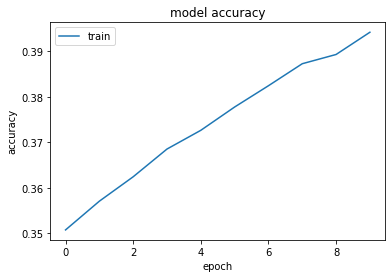

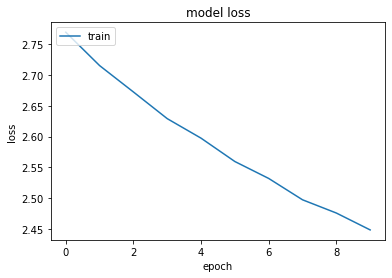

In [ ]:
#plotting model accuracy
# # summarize history for accuracy
plt.plot(model.history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # summarize history for loss
plt.plot(model.history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# load the weights of the model that was saved in the local
model = load_model("/content/gdrive/MyDrive/Assignments/DL_2/model_weights/model_.h5")

In [ ]:
# defining a predict_caption function to get the predictions done
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

**Prediction on test data**

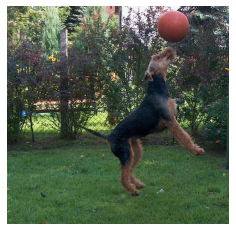

dog play with ball in the grass
['brown and black dog be jump up to catch red ball', 'brown and black dog jump for red ball', 'brown and black dog be jump to catch red ball', 'dog jump to get orange ball on his head']


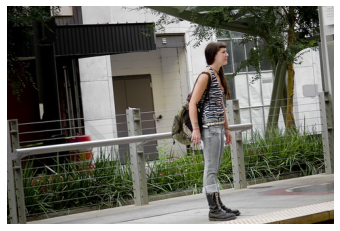

man in white shirt and white shirt be rollerblade on trampoline
['lady dress in shade of black wait on sidewalk for train', 'woman stand by wire fence on sidewalk']


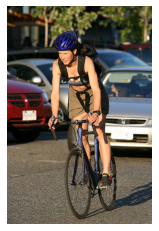

cyclist in an orange shirt and white helmet ride bicycle
['bicyclist ride on city street', 'woman in blue helmet and brown short ride her bike on busy street', 'woman be ride blue bike', 'woman be ride her bicycle in traffic']


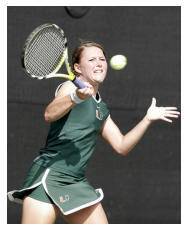

boy in blue shirt be swing up tennis ball
['female tennis player dress in green hit yellow ball', 'woman in green sport outfit be attempt to hit tennis ball with racket', 'tennis player hit the ball and make serious face']


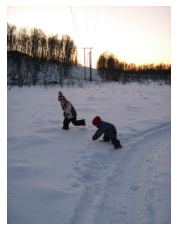

two dog be run through the snow
['two young child enjoy the snow']


In [ ]:
# printing five random  test images and predicting their captions
# we are also showing original captions as well
for i in range(5):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+"/"+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)
    print(map_dict[img_name])

**Take a random image from google and generate caption for that image.**

Image sucessfully Downloaded:  photo-1533693287076-186e5b4dc5e4?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1000&q=80


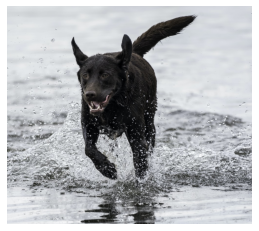

black dog run through the water


In [ ]:
## Set up the image URL and filename

image_url="https://images.unsplash.com/photo-1533693287076-186e5b4dc5e4?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1000&q=80"
filename = image_url.split("/")[-1]

# Open the url image, set stream to True, this will return the stream content.
r = requests.get(image_url, stream = True)

# Check if the image was retrieved successfully
if r.status_code == 200:
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    r.raw.decode_content = True
    
    # Open a local file with wb ( write binary ) permission.
    with open(filename,'wb') as f:
        shutil.copyfileobj(r.raw, f)
        
    print('Image sucessfully Downloaded: ',filename)
else:
    print('Image Couldn\'t be retreived')
photo = encode_image(filename).reshape((1,2048))

i = plt.imread(filename)
plt.imshow(i)
plt.axis("off")
plt.show()

caption = predict_caption(photo)
print(caption)